# NOTEBOOK 02: EDA

In this notebook the data collected in Notebook 01 will be used to determine the optimal vectorization method, suggest topic-specific stop words, and provide an initial comparaive analysis of word usage between classes.

In [1]:
import re, csv, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from sys import getsizeof
from nltk.tokenize import RegexpTokenizer

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer

%matplotlib inline

In [2]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[a-z]+_[a-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Word list saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Listing out the files in the assets folder to find the df of interest.

In [3]:
!ls '../assets/'

1544988010_comments_df.csv     1545277666_y_train.csv
1545241316_clean_target.csv    1545336727_SVD_col.csv
1545241316_clean_text.csv      1545336727_XtestSVD_coo.npz
1545266972_clean_text.csv      1545336727_XtrainSVD_coo.npz
1545266972_cvec_coo.npz        cvec_1545266972_coo_col.csv
1545272821_eda_words.csv       file_log.txt
1545277666_tfidf_col.csv       test_1545277666_tfidf_coo.npz
1545277666_y_test.csv          train_1545277666_tfidf_coo.npz


Reading in the csv to format as a dataframe.

In [4]:
df = pd.read_csv('../assets/1544988010_comments_df.csv', low_memory=False)

Confirming the shape of the dataframe corresponds with the exported original. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
author          200000 non-null object
body            200000 non-null object
libertarian     200000 non-null int64
created_utc     200000 non-null int64
subreddit_id    200000 non-null object
parent_id       200000 non-null object
link_id         200000 non-null object
permalink       200000 non-null object
dtypes: int64(2), object(6)
memory usage: 12.2+ MB


In [6]:
df.shape

(200000, 8)

Shape is correct. Reviewing the head to check data integrity.

In [7]:
df.head()

,author,body,libertarian,created_utc,subreddit_id,parent_id,link_id,permalink
0,spacefish3,"""Workers' collective ownership of capital"" nev...",1,1544931627,t5_2qh63,t1_eax5n3o,t3_a21e9n,/r/Libertarian/comments/a21e9n/the_admins_lied...
1,EatsPandas,hmmmmmmm interesting,1,1544931620,t5_2qh63,t3_a6lw8o,t3_a6lw8o,/r/Libertarian/comments/a6lw8o/libertarianism_...
2,KruglorTalks,"To be fair, credit to Cratchit just for litera...",1,1544931605,t5_2qh63,t3_a6k2kt,t3_a6k2kt,/r/Libertarian/comments/a6k2kt/scroogedidnothi...
3,Itl_chi_15,"Game show hosts, they’re are truly the worst. ...",1,1544931593,t5_2qh63,t3_a686wz,t3_a686wz,/r/Libertarian/comments/a686wz/not_every_actor...
4,seabreezeintheclouds,I think the better explanation is who are the ...,1,1544931588,t5_2qh63,t3_a6jrtf,t3_a6jrtf,/r/Libertarian/comments/a6jrtf/the_most_libert...


Checking for any comments that have been removed or deleted as they will not contribute to our analysis.

In [8]:
df[df['body'] == '[removed]'].shape

(15670, 8)

In [9]:
df[df['body'] == '[deleted]'].shape

(36, 8)

15706 observations have no signal and will be removed from the dataset.

In [10]:
df.drop(df[df['body'] == '[removed]'].index, axis=0, inplace=True)
df.drop(df[df['body'] == '[deleted]'].index, axis=0, inplace=True)

Resetting the index.

In [11]:
df.reset_index(drop=True, inplace=True)

Checking the shape of the processed dataframe.

In [12]:
df.shape

(184294, 8)

Checking the class balance.

In [13]:
df['libertarian'].value_counts(normalize=True)

1    0.538536
0    0.461464
Name: libertarian, dtype: float64

Since this only creates a 7% class imbalance we will consider this within the acceptable margin without requiring oversampling or other class balancing techniques. This will represent our baseline model, assuming every prediction to take on the majority class of libertarian with an accuracy of 53.8%. To be sure the negative class is represented equally in our training data we will stratify on y.

## Data Visualization

Splitting the dataframe into just the features used for modeling.

In [14]:
words = pd.DataFrame(df,columns=['body','libertarian'])
target = pd.DataFrame(df['libertarian'])

Comparing the character count and word count for each class.

In [15]:
words['char_count'] = words['body'].map(len)

In [16]:
words['word_count'] = words['body'].map(lambda x: len(x.split()))

Confirming output before plotting.

In [17]:
words.head()

,body,libertarian,char_count,word_count
0,"""Workers' collective ownership of capital"" nev...",1,81,12
1,hmmmmmmm interesting,1,20,2
2,"To be fair, credit to Cratchit just for litera...",1,82,15
3,"Game show hosts, they’re are truly the worst. ...",1,68,11
4,I think the better explanation is who are the ...,1,73,12


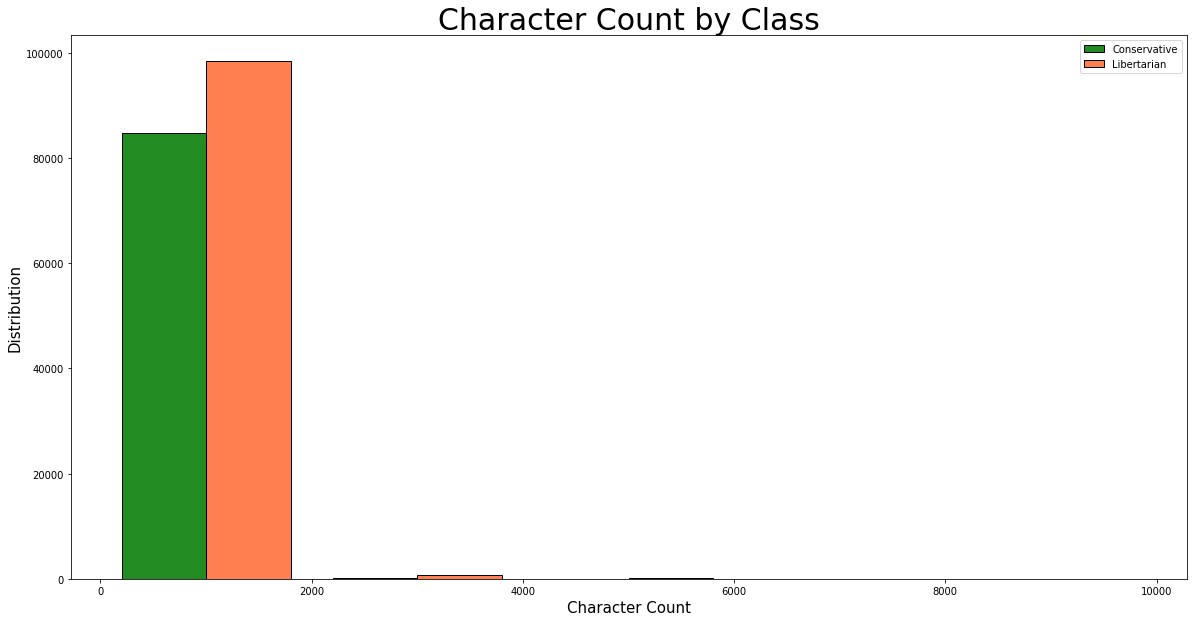

In [18]:
plt.figure(figsize=(20,10))
plt.hist([words['char_count'][words['libertarian']==0], 
          words['char_count'][words['libertarian']==1]],
         bins=5, 
         color=['forestgreen', 'coral'], 
         ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.xlabel('Character Count', fontsize=15)
plt.ylabel('Distribution', fontsize = 15)
plt.legend(['Conservative', 'Libertarian']);

The side-by-side bar plot shows that the vast majority of the samples contain less than 2000 characters. To make this figure more informative, I will split this data into bins of <=2000 & >2000 characters.

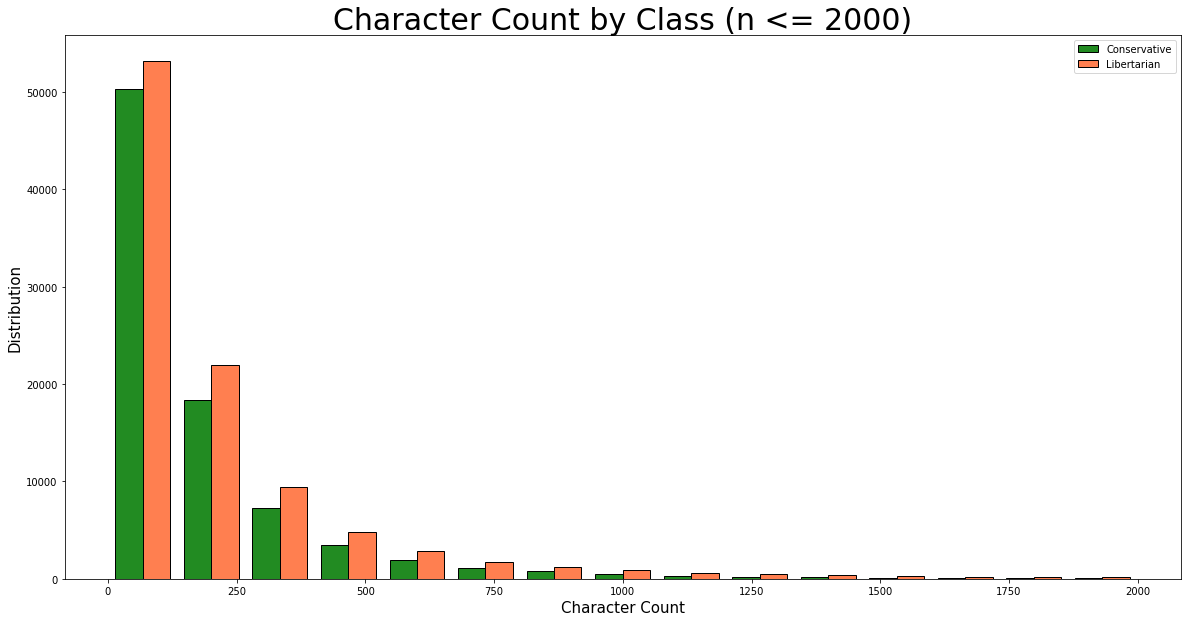

In [19]:
plt.figure(figsize=(20,10))
plt.hist([words['char_count'][(words['libertarian']==0) & (words['char_count']<=2000)], 
          words['char_count'][(words['libertarian']==1) & (words['char_count']<=2000)]],
         bins=15, 
         color=['forestgreen', 'coral'], 
         ec='k')
plt.title('Character Count by Class (n <= 2000)', fontsize=30)
plt.xlabel('Character Count', fontsize=15)
plt.ylabel('Distribution', fontsize = 15)
plt.legend(['Conservative', 'Libertarian']);

# plt.savefig('../images/char_count.png', dpi=300)

This plot shows that the Libertarian comments are consistently longer than the Conservative comments. 

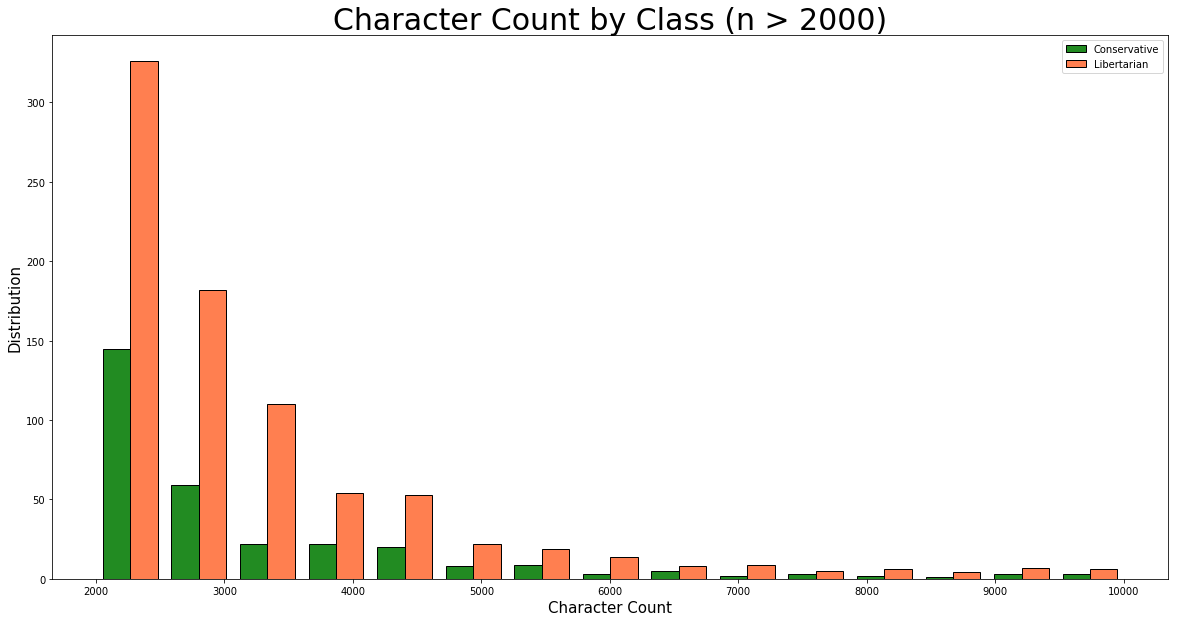

In [20]:
plt.figure(figsize=(20,10))
plt.hist([words['char_count'][(words['libertarian']==0) & (words['char_count']>2000)], 
          words['char_count'][(words['libertarian']==1) & (words['char_count']>2000)]],
         bins=15, 
         color=['forestgreen', 'coral'], 
         ec='k')
plt.title('Character Count by Class (n > 2000)', fontsize=30)
plt.xlabel('Character Count', fontsize=15)
plt.ylabel('Distribution', fontsize = 15)
plt.legend(['Conservative', 'Libertarian']);

# plt.savefig('../images/char2000_count.png', dpi=300)

At the higher end of character count, the distribution observed in the previous plot is maintained and the Libertarian comments are consistently longer for all values. The next set of plots will show if this holds true when viewing as a word count.

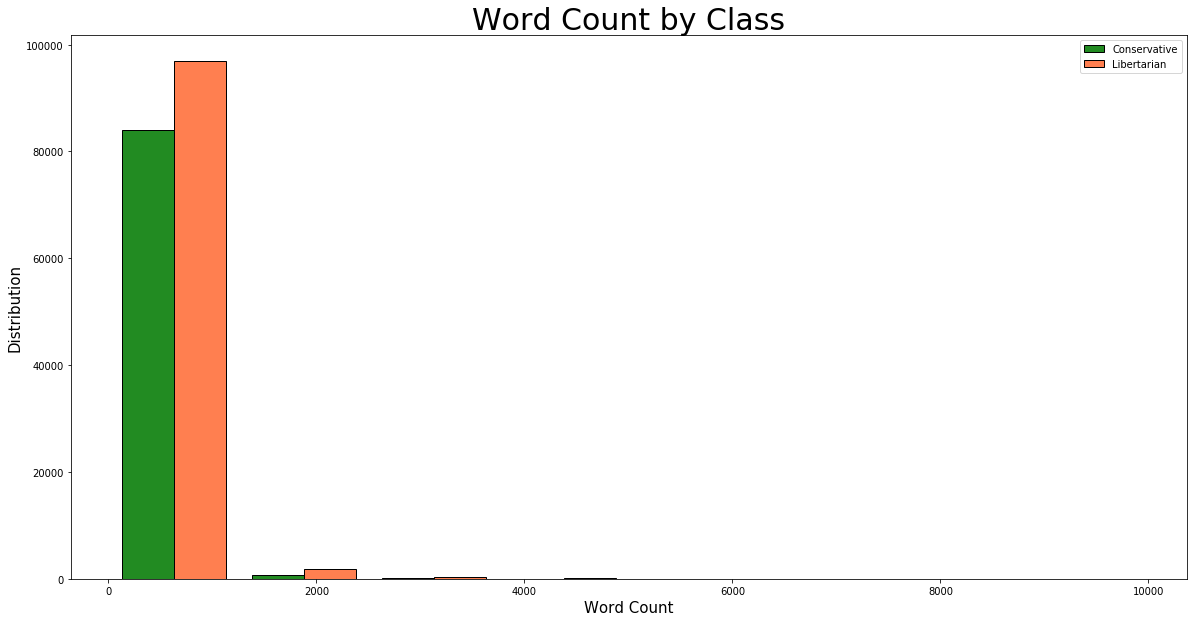

In [21]:
plt.figure(figsize=(20,10))
plt.hist([words['char_count'][words['libertarian']==0], 
          words['char_count'][words['libertarian']==1]],
         bins=8, 
         color=['forestgreen', 'coral'], 
         ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.xlabel('Word Count', fontsize=15)
plt.ylabel('Distribution', fontsize = 15)
plt.legend(['Conservative', 'Libertarian']);

The word count of most posts is less than 1000 words. To get a better understanding of this distribution, the plots will again be split.

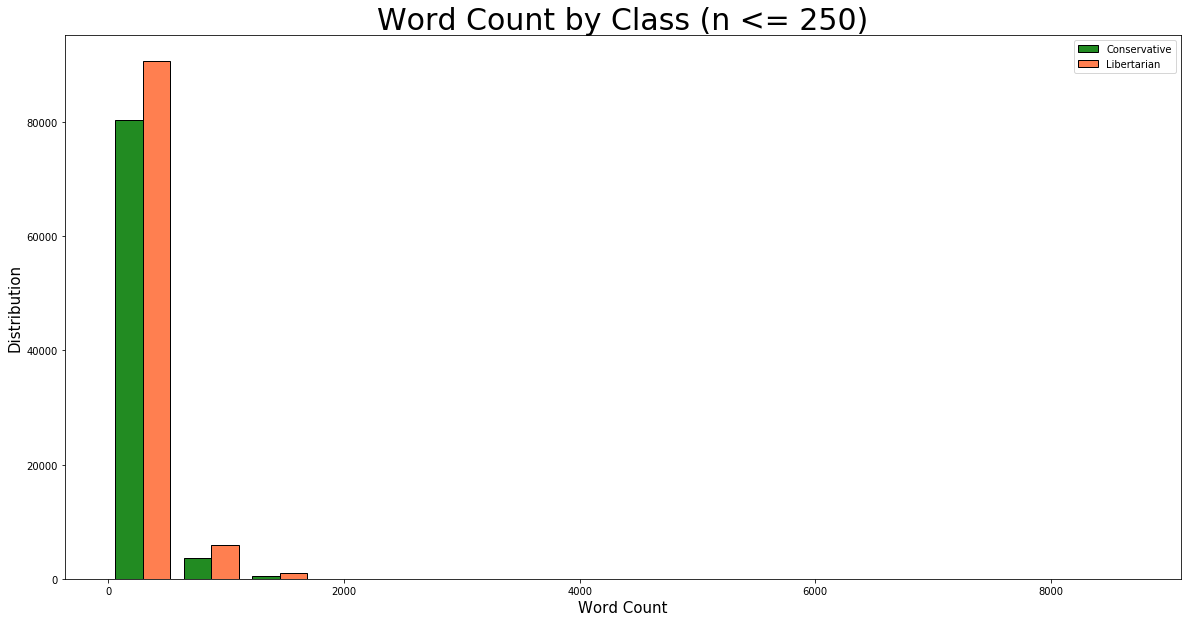

In [22]:
plt.figure(figsize=(20,10))
plt.hist([words['char_count'][(words['libertarian']==0) & (words['word_count']<=250)], 
          words['char_count'][(words['libertarian']==1) & (words['word_count']<=250)]],
         bins=15, 
         color=['forestgreen', 'coral'], 
         ec='k')
plt.title('Word Count by Class (n <= 250)', fontsize=30)
plt.xlabel('Word Count', fontsize=15)
plt.ylabel('Distribution', fontsize = 15)
plt.legend(['Conservative', 'Libertarian']);

Nearly half of the samples contain fewer than 250 words. Again, it seems that Libertarian comments are longer than Conservative comments.

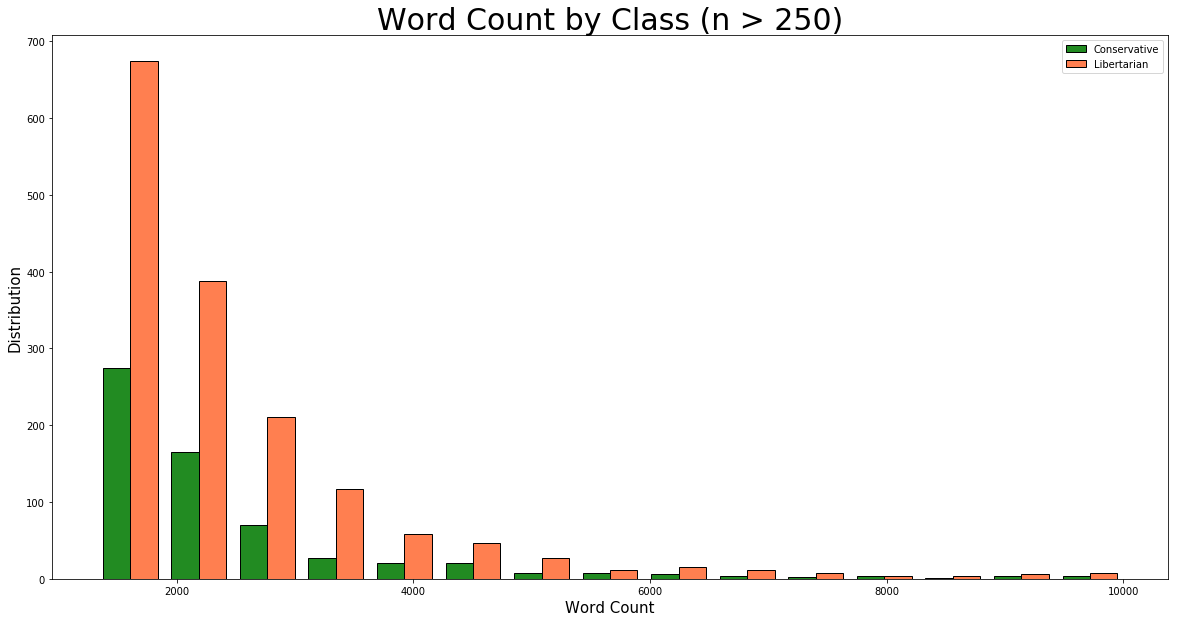

In [23]:
plt.figure(figsize=(20,10))
plt.hist([words['char_count'][(words['libertarian']==0) & (words['word_count']>250)], 
          words['char_count'][(words['libertarian']==1) & (words['word_count']>250)]],
         bins=15, 
         color=['forestgreen', 'coral'], 
         ec='k')
plt.title('Word Count by Class (n > 250)', fontsize=30)
plt.xlabel('Word Count', fontsize=15)
plt.ylabel('Distribution', fontsize = 15)
plt.legend(['Conservative', 'Libertarian']);

# plt.savefig('../images/word250_comp.png', dpi=300)

The other half of the dataset is more distributed, showing a similar decline among both subreddits. At 8000 words both subreddits appear to have an equal number of samples.

## Cleaning Text, Tokenizing, Lemmatizing, and Count Vectorizing

Cleaning the text by removing subreddit links, urls, initial stop words, and any punctuation or special characters except the (') in contractions.

In [24]:
words['body'] = words.body.map(lambda x: re.sub('\s[\/]?r\/[^\s]+',' ', x))

words['body'] = words.body.map(lambda x: re.sub('http[s]?:\/\/[^\s]*|[^\s]*\.\w{2,3}', ' ', x))

words['body'] = words.body.map(lambda x: re.sub('(conservative|libertarian|trump)[s]?', ' ', x, flags=re.I&re.M))

words['body'] = words.body.map(lambda x: re.sub('[^A-z0-9|\w+\'\w+]', ' ', x))

Tokenizing the text before lemmatizing to reduce the size of the feature space. After lemmatizing words to their root form the text will be rejoined ahead of vectorization.

In [25]:
lemma = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+\s|\$\d+[\.\d{2,2}]?|\S+|[\w']+")

words['tokens'] = words.body.map(lambda x: tokenizer.tokenize(x.lower()))

words['tokens'] = words.tokens.map(lambda x: [lemma.lemmatize(word) for word in x])

words['tokens'] = words.tokens.map(lambda x: ' '.join([word for word in x]))

Checking to see how many samples were eliminated after text cleaning. Since these samples provide no signal they will be eliminated from our dataset.

In [26]:
words[words['tokens']==''].libertarian.value_counts()

1    468
0    451
Name: libertarian, dtype: int64

Since there is a roughly equal number of samples being removed from each class our class balance has been preserved.

In [28]:
words.drop(words[words['tokens'] == ''].index, axis=0, inplace=True)

In [29]:
words.reset_index(drop=True, inplace=True)

In [30]:
words.head()

,body,libertarian,char_count,word_count,tokens
0,Workers' collective ownership of capital nev...,1,81,12,workers' collective ownership of capital n...
1,hmmmmmmm interesting,1,20,2,hmmmmmmm interesting
2,To be fair credit to Cratchit just for litera...,1,82,15,to be fair credit to cratchit just for ...
3,Game show hosts they re are truly the worst ...,1,68,11,game show hosts they re are truly the ...
4,I think the better explanation is who are the ...,1,73,12,i think the better explanation is who a...


Saving out the cleaned sample list for splitting into model training and validation sets before CountVectorization and alternative word vectorization techniques such as Tfidf.

In [31]:
formatted_name, now, file_description = filename_format_log(file_path ='../assets/eda_words.csv')
words.to_csv(formatted_name, index=False)

In addition to the standard set of english stop words, some topic-specific terms will also be excluded to prevent the classification models from assigning undue importance to features that would be uninformative for our investigation. Identifying words such as "conservative" or "libertarian" do not assist in elucidating more insighful terms. 

In [27]:
custom_stop = [
    'conservative',
    'conservatives',
    'libertarian',
    'libertarians',
    'don',
    'isn',
    'say',
    'way',
    'really',
    'things',
    'going',
    'actually',
    'make',
    've',
    'gt',
    'doesn',
    'does',
    'know',
    'good',
    'want',
    'did',
    'pay',
    'use',
    'thing',
    'sure',
    'didn',
    'like',
    'just',
    'did',
    'll',
    'bad',
    'need',
    'let',
    'lot',
    'libertarian',
    'yes',
    'sub',
    'said',
    'saying',
    'pretty',
    'got',
    'amp',
    'shit',
    'look',
    'aren',
    'x200b',
    '32',
    '43',
    '31',
    '000',
    'yeah',
    'wikitextbot',
    'sneakpeekbot',
    'imguralbumbot',
    
    
]

stop_words = ENGLISH_STOP_WORDS.union(custom_stop)

In [28]:
stop_words;

The target feature will be pulled out so it can be joined back into the resulting vectorized dataframe.

In [29]:
target = words['libertarian']

In [30]:
target.value_counts(normalize=True)

1    0.538536
0    0.461464
Name: libertarian, dtype: float64

Count Vectorizing the text in preparation for model fitting. Below, the CountVectorizer function will be fit to strip accents, remove stop words, convert the text to lowercase, drop words that appear fewer than 15 times throughout the sample-space, and allow words to be used within every document as needed. 

In [31]:
cvec = CountVectorizer(strip_accents = 'unicode',  
                       stop_words = stop_words, 
                       lowercase = True, 
                       min_df = 15, 
                       max_df = 1.0)

Transforming the cleaned data and saving out to a clean variable for plotting.

In [32]:
cvec_mat = cvec.fit_transform(words['tokens'])

Checking the feature-space of the vectorized matrix.

In [33]:
len(cvec.get_feature_names())

13122

Converting the word vector into a sparse dataframe.

In [34]:
cvec_df = pd.SparseDataFrame(cvec_mat, columns=cvec.get_feature_names() )

Adding the classification for sorting by class.

In [35]:
cvec_df['libertarian'] = target

Sorting the most frequently used words in the Libertarian comments in descending order, discounting the classification feature.

In [36]:
cvec_df[cvec_df['libertarian'] == 1].sum().sort_values(ascending=False)

libertarian     99249.0
people          23264.0
government      10882.0
think           10480.0
right            9747.0
free             5759.0
time             5415.0
work             5260.0
point            5164.0
state            4845.0
money            4686.0
property         3772.0
mean             3648.0
trump            3639.0
better           3604.0
taxes            3518.0
rights           3455.0
tax              3416.0
left             3383.0
market           3353.0
believe          3294.0
person           3203.0
power            3178.0
private          3165.0
capitalism       3049.0
life             2968.0
world            2922.0
agree            2857.0
wrong            2834.0
means            2832.0
                 ...   
gillum              0.0
foreskin            0.0
kemp                0.0
subpoenas           0.0
maricopa            0.0
circumcised         0.0
uncounted           0.0
uncover             0.0
motorcade           0.0
strongholds         0.0
tester          

Sorting the most frequently used words in the Conservative comments in descending order.

In [37]:
cvec_df[cvec_df['libertarian'] == 0].sum().sort_values(ascending=False)

people                   13420.0
think                     7534.0
trump                     6303.0
right                     5651.0
time                      4397.0
left                      4057.0
government                3301.0
years                     3052.0
vote                      3007.0
point                     2970.0
state                     2828.0
country                   2605.0
white                     2286.0
believe                   2225.0
democrats                 2222.0
president                 2205.0
mean                      2146.0
house                     2134.0
work                      2078.0
news                      2056.0
money                     2035.0
better                    2008.0
media                     1989.0
party                     1982.0
person                    1980.0
election                  1971.0
political                 1961.0
life                      1955.0
man                       1941.0
law                       1850.0
          

Collecting the top 500 words for each subreddit

In [38]:
cvec_500_cons = list(cvec_df[cvec_df['libertarian']==0].
     mean().T.sort_values(ascending=False).head(500).index)

cvec_500_libr = list(cvec_df[cvec_df['libertarian']==1].
     mean().T.sort_values(ascending=False).head(500).index)

Pulling out overlapping words to compare frequency and occurance.

In [39]:
cvec_overlap = [word for word in cvec_500_libr if word in cvec_500_cons]

Listing the overlapping words.

In [40]:
cvec_overlap

['blah',
 'reassignment',
 'womp',
 'ding',
 'kate',
 'pakistani',
 'wikileaks',
 'incitement',
 'co2',
 'hoover',
 'cough',
 'steele',
 'hemp',
 'bulls',
 'fentanyl',
 'gun',
 'aliens',
 'insurance',
 'nasa',
 'firearm',
 'chromosome',
 'pit',
 'mugger',
 'ec',
 'electors',
 'women',
 'preexisting',
 'israel',
 'loophole',
 'marriage',
 'asylum',
 'fetus',
 'col',
 'eo',
 'islamist',
 'cursive',
 'motherhood',
 'curing',
 'chomsky',
 'solar',
 'percent',
 'officers',
 'tax',
 'people',
 'speech',
 'nurse',
 'gender',
 'probability',
 'sex',
 'government',
 'temperature',
 'cookies',
 'lease',
 'immigrants',
 'operators',
 'cannabis',
 'tariffs',
 'physicians',
 'cohen',
 'gap',
 'tariff',
 'cite_note',
 'matthew',
 'oregon',
 'ip',
 'abortion',
 'healthcare',
 'organism',
 'fires',
 'immigration',
 'sherman',
 'robin',
 'rail',
 'firms',
 'data',
 'commune',
 'ballots',
 'steel',
 'men',
 'treaties',
 'embryo',
 'aclu',
 'child',
 'rape',
 'jobs',
 'genes',
 'apple',
 'human',
 'state

Defining a plotting function for comparing the frequency and number of observations as well as the mean usage for each word in the ovelap set. Code inspired by D. Strodman.

In [41]:
def plot_wordvec_dist(words, dataframe, target = 'libertarian', classes = [0,1]):
    nrows = len(words[:10])//2 if not len(words[:10])%2 else len(words)//2 + 1
    class_0 = dataframe[dataframe[target]==classes[0]]
    class_1 = dataframe[dataframe[target]==classes[1]]
    fig, ax = plt.subplots(ncols=2, nrows=nrows, figsize=(20, 7*nrows))
    ax = ax.ravel()
    
    for i, word in enumerate(words[:10]):
        counts_0 = class_0[word].value_counts().to_dict()
        counts_1 = class_1[word].value_counts().to_dict()
        mean_0 = class_0[word].mean()
        mean_1 = class_1[word].mean()
        ax[i].bar(counts_0.keys(), counts_0.values(), color='forestgreen', alpha=.3)
        ax[i].bar(counts_1.keys(), counts_1.values(), color='coral', alpha=.3)
        ymin, ymax = ax[i].get_ylim()
        ax[i].set_xlabel('Frequency', fontsize=15)
        ax[i].set_ylabel('Observations', fontsize=15)
        ax[i].plot([mean_0]*2, [ymin, ymax], ':', color='forestgreen')
        ax[i].plot([mean_1]*2, [ymin, ymax], ':', color='coral')
        ax[i].set_title(f'{word} frequency counts\nmeans: {mean_0:0.03f} vs {mean_1:0.03f}', fontsize=15)
        ax[i].legend(labels=['Conservative', 'Libertarian']);
        
    plt.tight_layout()

Invoking the plotting function.

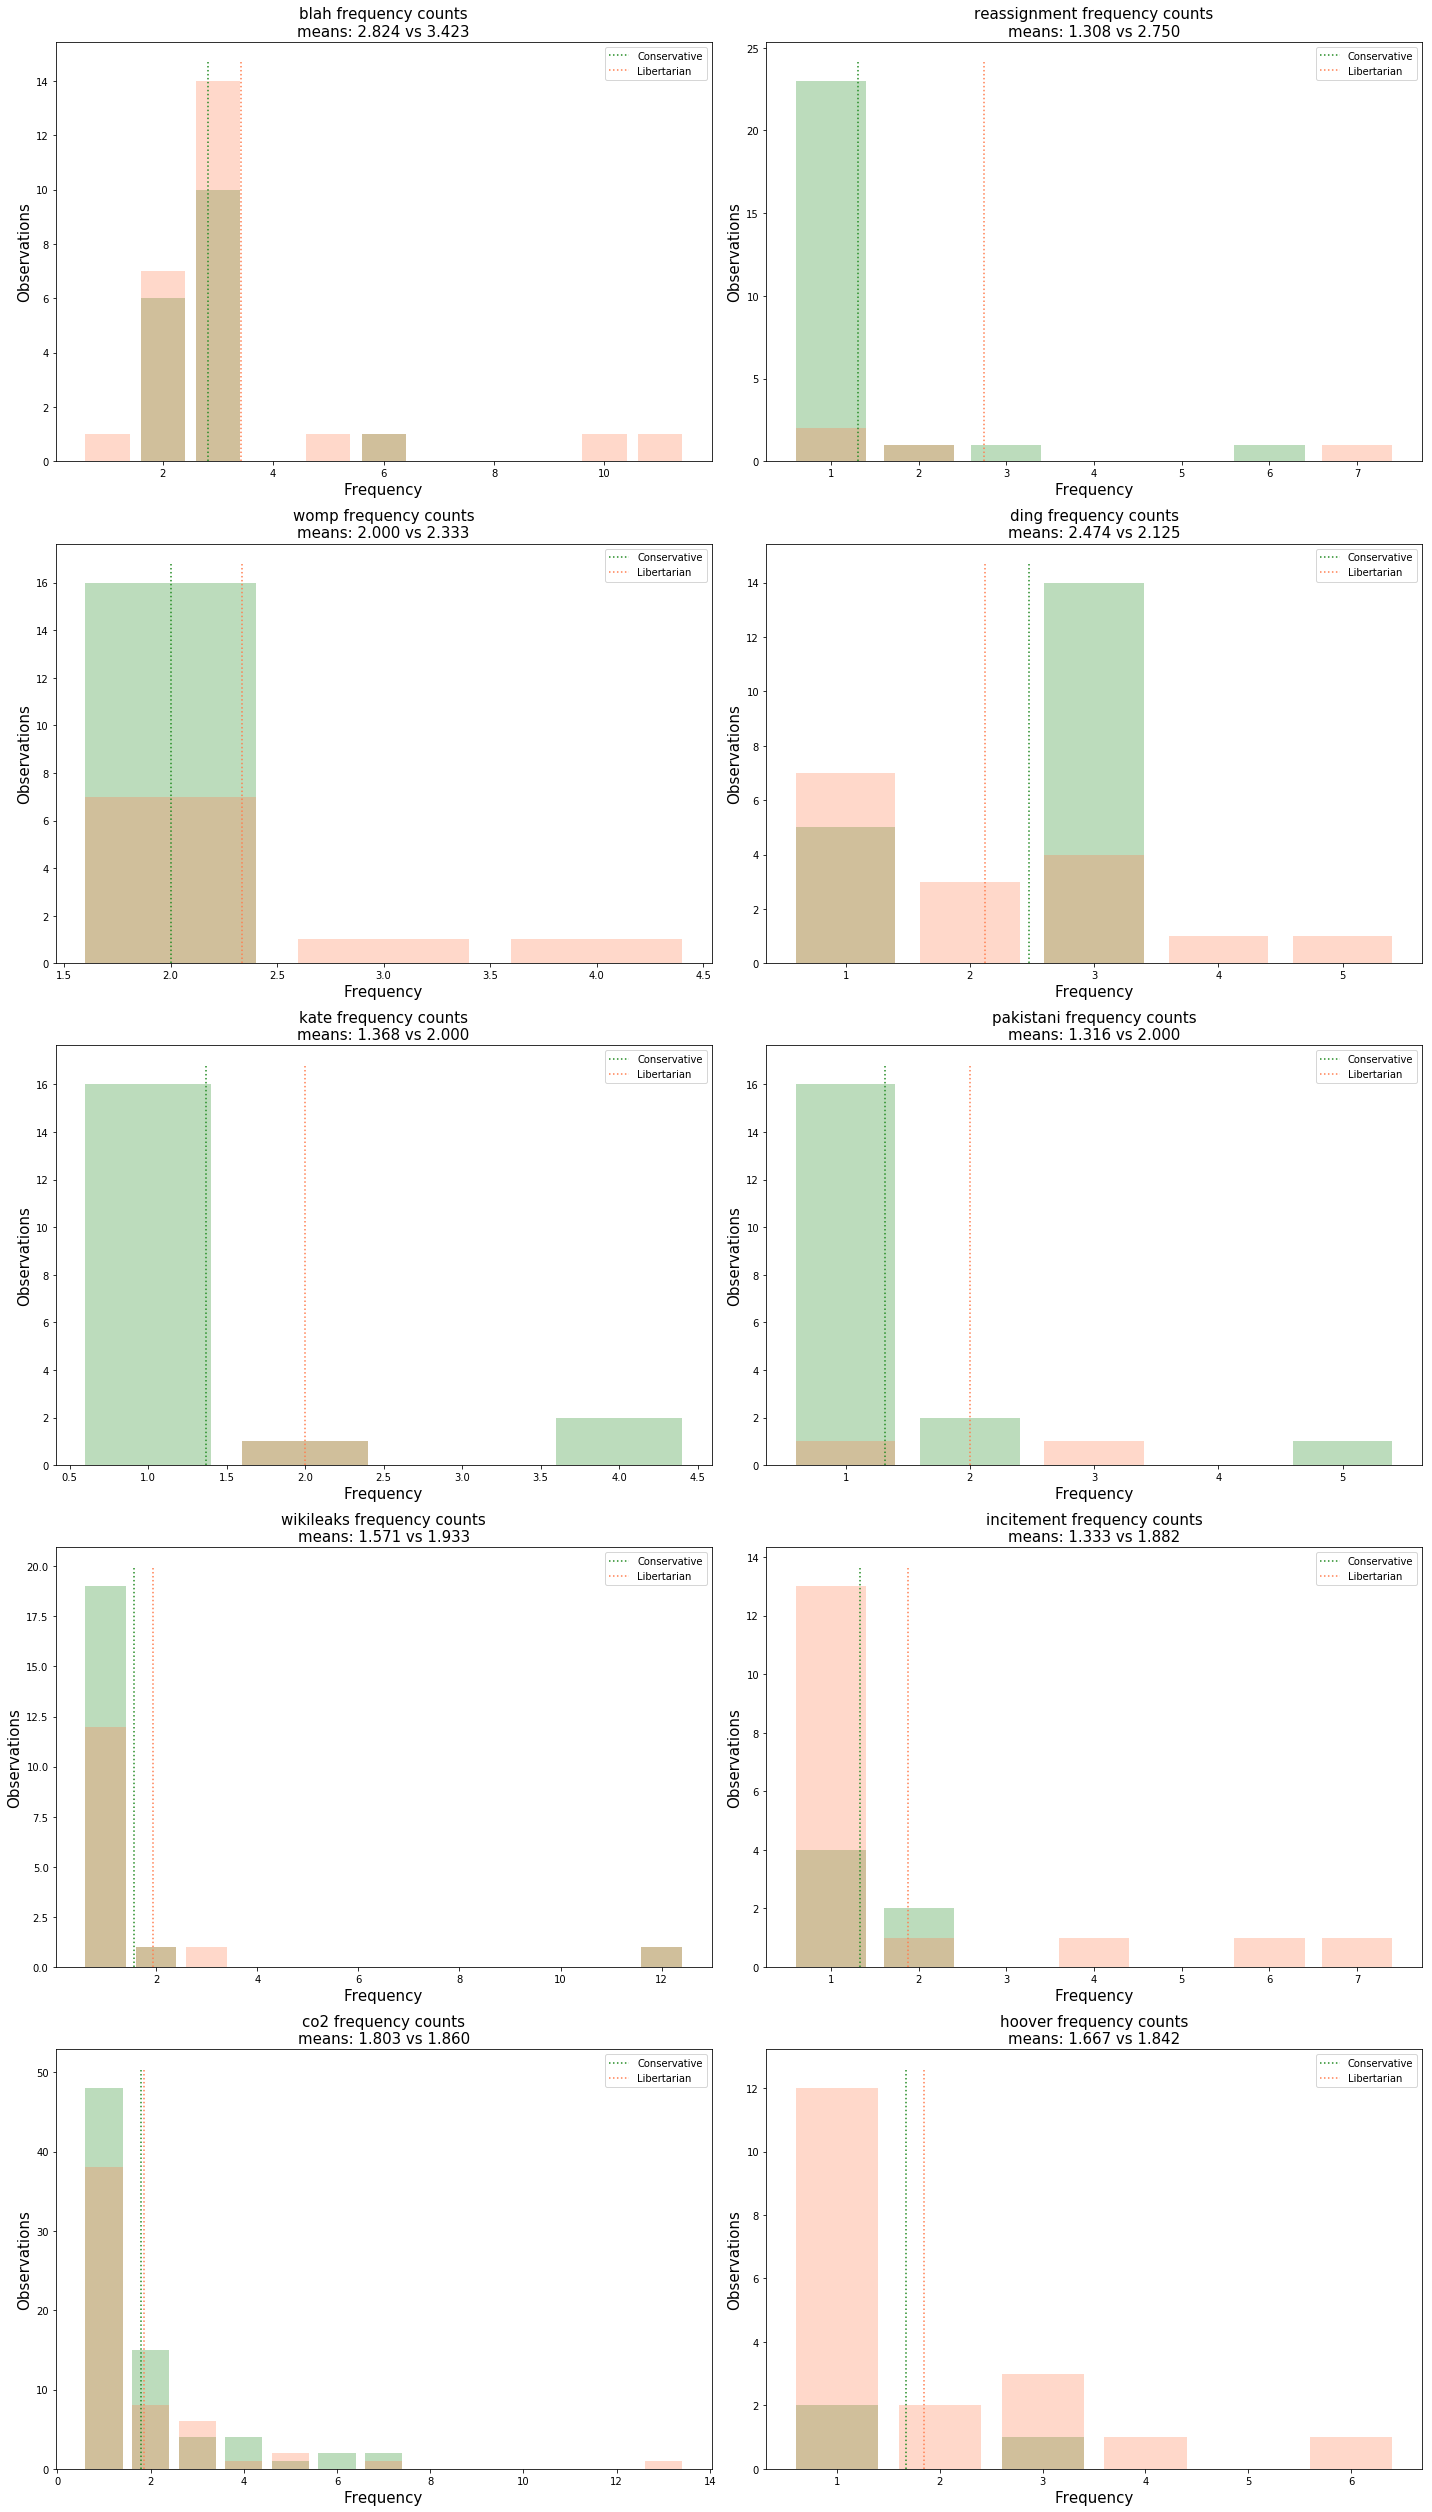

In [42]:
plot_wordvec_dist(cvec_overlap, cvec_df)

# plt.savefig('../images/cvec_overlap.png', dpi=300)

Plotting the top 10 overlapping terms after count vectorization. While some of these terms do not intuitively seem linked to one class or another, it is interesting to see there is pronounced class variance which suggests that there is a true signal which may be predictive after fitting models. 'Reassignment', 'Pakistani', 'incitement', 'co2', and 'hoover' seem to have the most class variance among the more politically relavent overlap words.

Reloading the clean data for Tfidf Vectorization. Tfidf accounts for the usage of a word within a set of documents and regularizes the counts to allow rare terms to carry more weight. In this way, it may help limit the influence of common words used in web comments that are not part of a standard English language stop list, thereby increasing the chance that important terms will be fit during modeling.

In [32]:
!ls '../assets/'

1544820504_comments_df.csv   1545266972_clean_text.csv
1544843302_comments_df.csv   1545266972_cvec_coo.npz
1544988010_comments_df.csv   1545266972_tfidf_coo.npz
1545241316_clean_target.csv  1545272821_eda_words.csv
1545241316_clean_text.csv    cvec_1545266972_coo_col.csv
1545249401_cvec_coo.npz      file_log.txt
1545249401_cvec_coo_col.csv  tfidf_1545266972_coo_col.csv
1545254581_clean_text.csv


In [43]:
clean_words = pd.read_csv('../assets/1545272821_eda_words.csv', na_filter=False)

Saving out the target

In [44]:
clean_target = clean_words['libertarian']

In [45]:
clean_words.head()

,body,libertarian,char_count,word_count,tokens
0,Workers' collective ownership of capital nev...,1,81,12,workers' collective ownership of capital n...
1,hmmmmmmm interesting,1,20,2,hmmmmmmm interesting
2,To be fair credit to Cratchit just for litera...,1,82,15,to be fair credit to cratchit just for ...
3,Game show hosts they re are truly the worst ...,1,68,11,game show hosts they re are truly the ...
4,I think the better explanation is who are the ...,1,73,12,i think the better explanation is who a...


Tfidf vectorizing with the same parameters as the Count Vectorization.

In [46]:
tfidf = TfidfVectorizer(strip_accents = 'unicode',  
                        stop_words = stop_words, 
                        lowercase = True, 
                        min_df = 15, 
                        max_df = 1.0)

Fitting and transforming the data.

In [47]:
tfidf_mat = tfidf.fit_transform(clean_words['tokens'])

Checking the size of the feature space

In [49]:
len(tfidf.get_feature_names())

13122

Converting to a sparse dataframe

In [50]:
tfidf_df = pd.SparseDataFrame(tfidf_mat, columns=tfidf.get_feature_names())

Adding back the target for a comparitive analysis of word usage between classes.

In [51]:
tfidf_df['libertarian'] = clean_target

Sorting the most frequently used words in the Libertarian comments in descending order, discounting the classification feature.

In [52]:
tfidf_df[tfidf_df['libertarian'] == 1].sum().sort_values(ascending=False)

libertarian     98781.000000
people           2074.920662
government       1292.175239
right            1251.465636
think            1226.327080
free              822.118587
point             738.298805
time              675.578198
work              663.051849
lol               660.061195
money             618.535580
state             604.734412
mean              600.920898
fuck              591.256705
post              576.932377
taxes             568.602766
property          543.203309
trump             542.138157
capitalism        527.631652
better            527.049455
tax               519.965285
wrong             510.495704
socialism         508.646383
left              500.993180
agree             493.110589
rights            468.958382
believe           468.828535
private           456.324334
power             450.590016
market            450.417190
                    ...     
stabenow            0.000000
uncounted           0.000000
tester              0.000000
milano        

Sorting the most frequently used words in the Conservative comments in descending order.

In [53]:
tfidf_df[tfidf_df['libertarian'] == 0].sum().sort_values(ascending=False)

people                   1322.282355
think                     988.073370
trump                     933.369432
right                     812.800380
time                      654.190641
left                      627.973491
vote                      540.125910
lol                       505.165522
years                     469.493224
point                     461.425142
man                       427.282273
democrats                 424.172182
country                   416.221673
mean                      408.003671
house                     402.834264
government                400.921706
state                     395.255920
news                      394.359175
president                 391.736220
white                     391.718354
election                  376.945801
believe                   364.475786
wrong                     356.741386
won                       355.739527
agree                     347.536909
better                    344.212346
media                     342.847778
p

Collecting the top 500 words for each subreddit

In [54]:
tfidf_500_cons = list(tfidf_df[tfidf_df['libertarian']==0].
     mean().T.sort_values(ascending=False).head(500).index)

tfidf_500_libr = list(tfidf_df[tfidf_df['libertarian']==1].
     mean().T.sort_values(ascending=False).head(500).index)

Pulling out overlapping words to compare frequency and occurance.

In [55]:
tfidf_overlap = [word for word in tfidf_500_libr if word in tfidf_500_cons]

Listing the overlapping words.

In [56]:
tfidf_overlap

['si',
 'whoosh',
 'womp',
 'derp',
 'amen',
 'touche',
 'intensifies',
 'felicia',
 'remindme',
 'm8',
 'cortex',
 'plz',
 'ouch',
 'wat',
 'fag',
 'poe',
 'bye',
 'ding',
 'backfired',
 'wut',
 'blah',
 'thots',
 'topminds',
 'misspelled',
 'godwin',
 'underrated',
 'remembers',
 'kek',
 'allot',
 'bruh',
 'copypasta',
 'chapotardhouse',
 'fucktard',
 'yawn',
 'concur',
 'sayin',
 'dammit',
 'aww',
 'oof',
 'clap',
 'champ',
 'reichstag',
 'cucks',
 'checkmate',
 'laughs',
 'wack',
 'tf',
 'thot',
 'stonetoss',
 'comrade',
 'nsfw',
 'username',
 'gif',
 'optimism',
 'tmor',
 'finest',
 'btfo',
 'funnier',
 'ooh',
 'sigh',
 'unironically',
 'lmfao',
 'crickets',
 'unsub',
 'spice',
 'doe',
 'chad',
 'classy',
 'hahahahaha',
 'cough',
 'stinky',
 'dat',
 'naw',
 'sarcasm',
 'ninja',
 'hahahaha',
 'snl',
 'boner',
 'yikes',
 'tfw',
 'dawg',
 'darth',
 'muted',
 'pls',
 'cock',
 'voat',
 'outoftheloop',
 'bingo',
 'ditto',
 'unbearable',
 'simpsons',
 'hmmmm',
 'tan',
 'sd',
 'hahahah',


Interesting to see a very different group of features identified by Tfidf vectorization. Given that there seems to be a much strong connection to politically relavent words in the Tfidf dataset for both classes, we will proceed with this data for modeling.

# CONTINUE TO NOTEBOOK 03